In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor # import the random forest model
from sklearn import  preprocessing # used for label encoding and imputing NaNs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score

import datetime as dt # we will need this to convert the date to a number of days since some point

from sklearn.tree import export_graphviz
from sklearn import tree

# Acceptance Status will be predicted using 3 models

In [2]:
claimsdata = pd.read_csv("processedData.csv")
claimsdata.head()

,Ticket Number,DateOfService,CarrierCode,Charges,Payments,InsurancePayment,PatientPayment,Writeoffs,InsuranceBal,PatientBal,...,CPT,DateOfEntry,PaymentPostDate,NPI,OrderingClinic,DeniedCode,FirstBilledDate,ProviderProfile,CaseCount,accepted
0,104452,1/2/2019,CFHP-E2,3900,0.0,0.0,0.0,0.0,0.0,3900.0,...,81507,1/7/2019,1/22/2019,1316428238,ALAMO WOMEN'S OBGYN,197,1/8/2019,NTINC,1,False
1,104453,1/2/2019,CFHP-E2,3900,0.0,0.0,0.0,0.0,0.0,3900.0,...,81507,1/7/2019,1/24/2019,1316428238,ALAMO WOMEN'S OBGYN,197,1/8/2019,NTINC,1,False
2,104454,1/2/2019,NCS,795,249.0,0.0,249.0,546.0,0.0,0.0,...,99999,1/7/2019,2/10/2019,1699760116,COMPREHENSIVE WOMEN'S HEALTHCARE,-,NaN,NTINC,1,True
3,104496,1/2/2019,AETLIF-E,3900,0.0,0.0,0.0,0.0,3900.0,0.0,...,81420,1/7/2019,1/28/2019,1609216597,PEACHTREE WOMEN'S CLINIC - NORTHSIDE,-,1/8/2019,NTINC,1,True
4,104497,1/2/2019,AETLIF-E,3900,0.0,0.0,0.0,0.0,3900.0,0.0,...,81420,1/7/2019,1/30/2019,1609216597,PEACHTREE WOMEN'S CLINIC - NORTHSIDE,-,1/8/2019,NTINC,1,True


In [3]:
#import the data as dates for date of service and 
claimsdata = pd.read_csv("processedData.csv", parse_dates=['DateOfService', 'FirstBilledDate'])
claimsdata.head()

,Ticket Number,DateOfService,CarrierCode,Charges,Payments,InsurancePayment,PatientPayment,Writeoffs,InsuranceBal,PatientBal,...,CPT,DateOfEntry,PaymentPostDate,NPI,OrderingClinic,DeniedCode,FirstBilledDate,ProviderProfile,CaseCount,accepted
0,104452,2019-01-02,CFHP-E2,3900,0.0,0.0,0.0,0.0,0.0,3900.0,...,81507,1/7/2019,1/22/2019,1316428238,ALAMO WOMEN'S OBGYN,197,2019-01-08,NTINC,1,False
1,104453,2019-01-02,CFHP-E2,3900,0.0,0.0,0.0,0.0,0.0,3900.0,...,81507,1/7/2019,1/24/2019,1316428238,ALAMO WOMEN'S OBGYN,197,2019-01-08,NTINC,1,False
2,104454,2019-01-02,NCS,795,249.0,0.0,249.0,546.0,0.0,0.0,...,99999,1/7/2019,2/10/2019,1699760116,COMPREHENSIVE WOMEN'S HEALTHCARE,-,NaT,NTINC,1,True
3,104496,2019-01-02,AETLIF-E,3900,0.0,0.0,0.0,0.0,3900.0,0.0,...,81420,1/7/2019,1/28/2019,1609216597,PEACHTREE WOMEN'S CLINIC - NORTHSIDE,-,2019-01-08,NTINC,1,True
4,104497,2019-01-02,AETLIF-E,3900,0.0,0.0,0.0,0.0,3900.0,0.0,...,81420,1/7/2019,1/30/2019,1609216597,PEACHTREE WOMEN'S CLINIC - NORTHSIDE,-,2019-01-08,NTINC,1,True


In [4]:
# Convert the date into a number (date gaps between DOS and FirstBilledDate)
claimsdata[claimsdata.FirstBilledDate.isnull()]

,Ticket Number,DateOfService,CarrierCode,Charges,Payments,InsurancePayment,PatientPayment,Writeoffs,InsuranceBal,PatientBal,...,CPT,DateOfEntry,PaymentPostDate,NPI,OrderingClinic,DeniedCode,FirstBilledDate,ProviderProfile,CaseCount,accepted
2,104454,2019-01-02,NCS,795,249.0,0.0,249.0,546.0,0.0,0.0,...,99999,1/7/2019,2/10/2019,1699760116,COMPREHENSIVE WOMEN'S HEALTHCARE,-,NaT,NTINC,1,True
50,116442,2019-01-02,SELF,1590,249.0,0.0,249.0,1341.0,0.0,0.0,...,99999,1/9/2019,1/22/2019,1497129134,ELITE WOMEN'S HEALTH,-,NaT,NTINC,1,True
146,120265,2019-01-02,NCS,795,249.0,0.0,249.0,546.0,0.0,0.0,...,99999,1/10/2019,1/31/2019,1699015362,OBSTETRICAL AND GYNECOLOGICAL ASSOCIATES,-,NaT,NTINC,1,True
194,123255,2019-01-02,SELF,1590,249.0,0.0,249.0,0.0,0.0,1341.0,...,99999,1/10/2019,2/13/2019,1831691401,MERCY BIRTHING CENTER - ST. LOUIS,-,NaT,NTINC,1,True
223,123576,2019-01-02,SELF,795,249.0,0.0,249.0,546.0,0.0,0.0,...,99999,1/10/2019,2/5/2019,1821555392,"ARBOR DIAGNOSTICS, INC (CLIENT BILL)",-,NaT,NTINC,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19933,292748,2019-01-02,SELF,1590,249.0,0.0,249.0,1341.0,0.0,0.0,...,99999,1/29/2019,2/13/2019,1114025749,FARIS A HANNA OBGYN,-,NaT,NTINC,1,True
20299,294099,2019-01-03,SELF,649,349.0,0.0,349.0,300.0,0.0,0.0,...,99999,1/29/2019,2/13/2019,1194991463,CAROLINAS FERTILITY INSTITUTE,-,NaT,NTINC,1,True
20644,294858,2019-01-07,NCS,795,249.0,0.0,249.0,546.0,0.0,0.0,...,99999,1/29/2019,2/10/2019,1750383048,NEW JERSEY PERINATAL- WESTFIELD,-,NaT,NTINC,1,True
21204,300561,2019-01-02,SELF,649,349.0,0.0,349.0,300.0,0.0,0.0,...,99999,1/30/2019,2/13/2019,1720068562,MAYO CLINIC,-,NaT,NTINC,1,True


As we have enough data, small number of data is NAT, we can drop those rows)

In [5]:
claimsdata = claimsdata.dropna(subset=['FirstBilledDate'])
claimsdata['timedelta'] = (claimsdata['FirstBilledDate'] - claimsdata['DateOfService']).dt.days.astype(int)
claimsdata[['DateOfService', 'FirstBilledDate', 'timedelta']].head()


,DateOfService,FirstBilledDate,timedelta
0,2019-01-02,2019-01-08,6
1,2019-01-02,2019-01-08,6
3,2019-01-02,2019-01-08,6
4,2019-01-02,2019-01-08,6
5,2019-01-02,2019-01-08,6


In [6]:
#Encoding categorical features
#naive approach and assign a numeric value to each categorical feature
#LabelEncoder()

In [7]:
claimsdata['NPI'] = claimsdata['NPI'].astype('object')
for c in claimsdata.columns:
    if claimsdata[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(claimsdata[c].values)) 
        claimsdata[c] = lbl.transform(list(claimsdata[c].values))

In [8]:
#categorical data preprocess done
claimsdata.head()

,Ticket Number,DateOfService,CarrierCode,Charges,Payments,InsurancePayment,PatientPayment,Writeoffs,InsuranceBal,PatientBal,...,DateOfEntry,PaymentPostDate,NPI,OrderingClinic,DeniedCode,FirstBilledDate,ProviderProfile,CaseCount,accepted,timedelta
0,104452,2019-01-02,119,3900,0.0,0.0,0.0,0.0,0.0,3900.0,...,16,8,894,44,27,2019-01-08,0,1,False,6
1,104453,2019-01-02,119,3900,0.0,0.0,0.0,0.0,0.0,3900.0,...,16,10,894,44,27,2019-01-08,0,1,False,6
3,104496,2019-01-02,14,3900,0.0,0.0,0.0,0.0,3900.0,0.0,...,16,13,1722,1077,0,2019-01-08,0,1,True,6
4,104497,2019-01-02,14,3900,0.0,0.0,0.0,0.0,3900.0,0.0,...,16,15,1722,1077,0,2019-01-08,0,1,True,6
5,104498,2019-01-02,14,4100,0.0,0.0,0.0,0.0,0.0,4100.0,...,16,13,1722,1077,69,2019-01-08,0,1,False,6


In [9]:
#remove unwanted columns
X_claims = claimsdata.drop(['Ticket Number', 'CaseCount', 'DateOfService', 'FirstBilledDate', 'DeniedCode', 'PaymentPostDate', 'DateOfEntry', 'accepted'], axis=1)
y_claims = claimsdata['accepted']

In [10]:
X_claims.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 22562 entries, 0 to 22695
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CarrierCode       22562 non-null  int64  
 1   Charges           22562 non-null  int64  
 2   Payments          22562 non-null  float64
 3   InsurancePayment  22562 non-null  float64
 4   PatientPayment    22562 non-null  float64
 5   Writeoffs         22562 non-null  float64
 6   InsuranceBal      22562 non-null  float64
 7   PatientBal        22562 non-null  float64
 8   AllowedAmount     22562 non-null  float64
 9   FinancialClass    22562 non-null  int64  
 10  CPT               22562 non-null  int64  
 11  NPI               22562 non-null  int64  
 12  OrderingClinic    22562 non-null  int64  
 13  ProviderProfile   22562 non-null  int64  
 14  timedelta         22562 non-null  int32  
dtypes: float64(7), int32(1), int64(7)
memory usage: 2.7 MB


In [11]:
X_claims.shape

(22562, 15)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_claims, y_claims, test_size = 0.20)

In [13]:
X_train.shape

(18049, 15)

In [14]:
X_test.shape

(4513, 15)

In [15]:
#decision tree

In [16]:
model = tree.DecisionTreeClassifier()

In [17]:
model.fit(X = X_train, y = y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [18]:
y_pred = model.predict(X_test)
# Check the training error
model.score(X_test, y_test)

0.9618878794593397

Feature Selection By Gradient Boost Tree for RandomForestClassifier

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [20]:
def run_randomForest(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy: ", accuracy_score(y_test,y_pred))
    print ("Classification report: ", classification_report(y_test, y_pred))
    return accuracy_score(y_test,y_pred)

In [21]:
def run_gradientBoostingForest(X_train, X_test, y_train, y_test):
    clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy: ", accuracy_score(y_test,y_pred))
    print ("Classification report: ", classification_report(y_test, y_pred))
    return accuracy_score(y_test,y_pred)

In [22]:
number_of_features = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
accuracy_random_forest_gradient_boost_RFE = [None,None,None,None,None,None,None,None,None,None,None,None,None,None,None]
accuracy_random_forest_random_forest_RFE = [None,None,None,None,None,None,None,None,None,None,None,None,None,None,None]
accuracy_gradient_boost_gradient_boost_RFE = [None,None,None,None,None,None,None,None,None,None,None,None,None,None,None]
accuracy_decision_tree_decision_tree_RFE = [None,None,None,None,None,None,None,None,None,None,None,None,None,None,None]
accuracy_decision_tree_gradient_boosting_RFE = [None,None,None,None,None,None,None,None,None,None,None,None,None,None,None]

In [23]:
for index in range(1, 16):
    gradientBoostRFELoop = RFE(GradientBoostingClassifier(n_estimators=100, random_state=0),n_features_to_select = index)
    gradientBoostRFELoop.fit(X_train,y_train)
    X_train_Grad_RFELoop = gradientBoostRFELoop.transform(X_train)
    X_test_Grad_RFELoop = gradientBoostRFELoop.transform(X_test)
    print("number of selected features:", index)
    accuracy_random_forest_gradient_boost_RFE[index-1] = run_randomForest(X_train_Grad_RFELoop, X_test_Grad_RFELoop, y_train, y_test)
    print()

number of selected features: 1
Accuracy:  0.7917128296033681
Classification report:                precision    recall  f1-score   support

       False       0.74      1.00      0.85      2692
        True       0.99      0.49      0.65      1821

    accuracy                           0.79      4513
   macro avg       0.87      0.74      0.75      4513
weighted avg       0.84      0.79      0.77      4513


number of selected features: 2
Accuracy:  0.8670507423000221
Classification report:                precision    recall  f1-score   support

       False       0.86      0.94      0.89      2692
        True       0.89      0.77      0.82      1821

    accuracy                           0.87      4513
   macro avg       0.87      0.85      0.86      4513
weighted avg       0.87      0.87      0.87      4513


number of selected features: 3
Accuracy:  0.8849988920895192
Classification report:                precision    recall  f1-score   support

       False       0.86      0.96 

Gradient Boosting Algorithm for RFE

In [24]:
for index in range (1, 16):
    gradientBoostRFELoop = RFE(GradientBoostingClassifier(n_estimators=100, random_state=0),n_features_to_select = index)
    gradientBoostRFELoop.fit(X_train,y_train)
    X_train_Grad_RFELoop = gradientBoostRFELoop.transform(X_train)
    X_test_Grad_RFELoop = gradientBoostRFELoop.transform(X_test)
    print("number of selected features:", index)
    accuracy_gradient_boost_gradient_boost_RFE[index-1] = run_gradientBoostingForest(X_train_Grad_RFELoop, X_test_Grad_RFELoop, y_train, y_test)
    print()

number of selected features: 1
Accuracy:  0.792377575891868
Classification report:                precision    recall  f1-score   support

       False       0.74      1.00      0.85      2692
        True       0.99      0.49      0.66      1821

    accuracy                           0.79      4513
   macro avg       0.87      0.74      0.75      4513
weighted avg       0.84      0.79      0.77      4513


number of selected features: 2
Accuracy:  0.8187458453356968
Classification report:                precision    recall  f1-score   support

       False       0.77      0.99      0.87      2692
        True       0.97      0.57      0.72      1821

    accuracy                           0.82      4513
   macro avg       0.87      0.78      0.79      4513
weighted avg       0.85      0.82      0.81      4513


number of selected features: 3
Accuracy:  0.8322623532018613
Classification report:                precision    recall  f1-score   support

       False       0.79      0.97  

Feature Selection By Random Forest for RandomForestClassifier

In [25]:
for index in range(1, 16):
    randomForestRFELoop = RFE(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1),n_features_to_select = index)
    randomForestRFELoop.fit(X_train,y_train)
    X_train_RandForest_RFELoop = randomForestRFELoop.transform(X_train)
    X_test_RandForest_RFELoop = randomForestRFELoop.transform(X_test)
    print("selected features:", index)
    accuracy_random_forest_random_forest_RFE[index-1] = run_randomForest(X_train_RandForest_RFELoop, X_test_RandForest_RFELoop, y_train, y_test)
    print()

selected features: 1
Accuracy:  0.8276091291823621
Classification report:                precision    recall  f1-score   support

       False       0.78      0.99      0.87      2692
        True       0.97      0.59      0.74      1821

    accuracy                           0.83      4513
   macro avg       0.87      0.79      0.80      4513
weighted avg       0.86      0.83      0.82      4513


selected features: 2
Accuracy:  0.895856414801684
Classification report:                precision    recall  f1-score   support

       False       0.89      0.94      0.91      2692
        True       0.90      0.84      0.87      1821

    accuracy                           0.90      4513
   macro avg       0.90      0.89      0.89      4513
weighted avg       0.90      0.90      0.90      4513


selected features: 3
Accuracy:  0.9091513405716818
Classification report:                precision    recall  f1-score   support

       False       0.91      0.95      0.93      2692
        Tru

Feature Selection By DecisionTree for DecisionTreeClassifier

In [26]:
def run_decisionTree(X_train, X_test, y_train, y_test):
    model = tree.DecisionTreeClassifier()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print("Score: ", model.score(X_test, y_test))
    print ("Classification report: ", classification_report(y_test, y_pred))
    return model.score(X_test, y_test)

In [27]:
for index in range(1, 16):
        decisionTreeRFELoop = RFE(tree.DecisionTreeClassifier(max_depth = 5),n_features_to_select = index)
        decisionTreeRFELoop.fit(X_train,y_train)
        X_train_DecisionTree_RFELoop = decisionTreeRFELoop.transform(X_train)
        X_test_DecisionTree_RFELoop = decisionTreeRFELoop.transform(X_test)
        print("selected features:", index)
        accuracy_decision_tree_decision_tree_RFE[index-1] = run_decisionTree(X_train_DecisionTree_RFELoop, X_test_DecisionTree_RFELoop, y_train, y_test)
        print()

selected features: 1
Score:  0.7914912475072015
Classification report:                precision    recall  f1-score   support

       False       0.74      1.00      0.85      2692
        True       0.99      0.49      0.65      1821

    accuracy                           0.79      4513
   macro avg       0.87      0.74      0.75      4513
weighted avg       0.84      0.79      0.77      4513


selected features: 2
Score:  0.8666075781076888
Classification report:                precision    recall  f1-score   support

       False       0.85      0.94      0.89      2692
        True       0.89      0.76      0.82      1821

    accuracy                           0.87      4513
   macro avg       0.87      0.85      0.86      4513
weighted avg       0.87      0.87      0.86      4513


selected features: 3
Score:  0.8852204741856858
Classification report:                precision    recall  f1-score   support

       False       0.86      0.96      0.91      2692
        True       

In [28]:
for index in range(1, 16):
        decisionTreeRFELoop = RFE(GradientBoostingClassifier(n_estimators=100, random_state=0),n_features_to_select = index)
        decisionTreeRFELoop.fit(X_train,y_train)
        X_train_DecisionTree_RFELoop = decisionTreeRFELoop.transform(X_train)
        X_test_DecisionTree_RFELoop = decisionTreeRFELoop.transform(X_test)
        print("selected features:", index)
        accuracy_decision_tree_gradient_boosting_RFE[index-1] = run_decisionTree(X_train_DecisionTree_RFELoop, X_test_DecisionTree_RFELoop, y_train, y_test)
        print()

selected features: 1
Score:  0.7914912475072015
Classification report:                precision    recall  f1-score   support

       False       0.74      1.00      0.85      2692
        True       0.99      0.49      0.65      1821

    accuracy                           0.79      4513
   macro avg       0.87      0.74      0.75      4513
weighted avg       0.84      0.79      0.77      4513


selected features: 2
Score:  0.8668291602038555
Classification report:                precision    recall  f1-score   support

       False       0.85      0.94      0.89      2692
        True       0.89      0.76      0.82      1821

    accuracy                           0.87      4513
   macro avg       0.87      0.85      0.86      4513
weighted avg       0.87      0.87      0.86      4513


selected features: 3
Score:  0.8849988920895192
Classification report:                precision    recall  f1-score   support

       False       0.86      0.96      0.91      2692
        True       

We can clearly see we have higher accuracy with all these classifiers for 11, 12 feature analysis

Random Forest with RFE using Gradient Boosting:
    number of selected features: 12
    Accuracy:  0.9703079991136716
Random Forest with RFE using Random Forest:
    selected features: 12
    Accuracy:  0.9703079991136716
Gradient Boosting with RFE using Gradient Boosting:
    number of selected features: 12
    Accuracy:  0.8909816086860182
Decision Tree with RFE using Decision Tree:
    selected features: 11
    Score:  0.9709727454021715
    max_depth: 6
for decision trees when max_depth increases model is overfitting, best one at max_depth 6


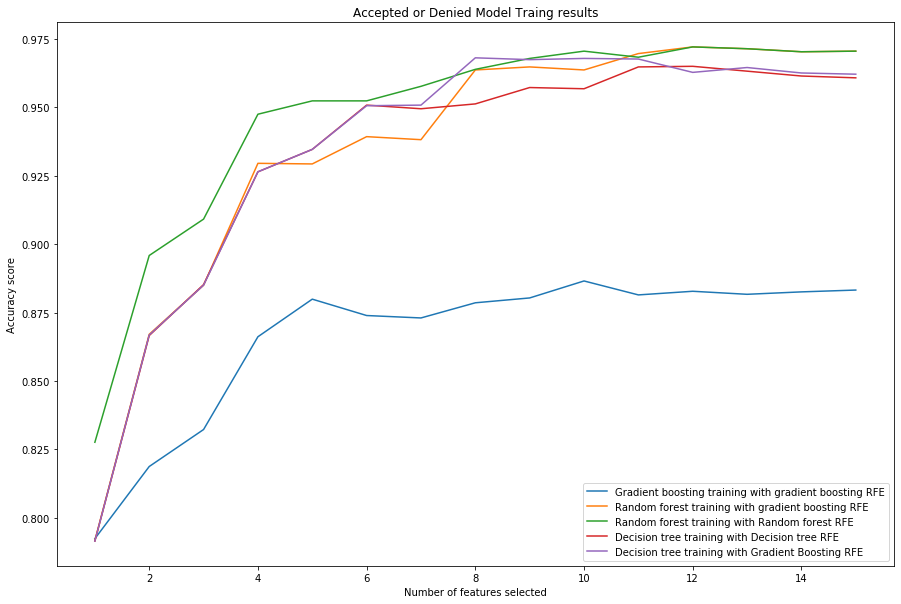

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))

# line 1 points
x1 = number_of_features
y1 = accuracy_gradient_boost_gradient_boost_RFE
# plotting the line 1 points 
plt.plot(x1, y1, label = "Gradient boosting training with gradient boosting RFE")

# line 2 points
x2 = number_of_features
y2 = accuracy_random_forest_gradient_boost_RFE
# plotting the line 1 points 
plt.plot(x2, y2, label = "Random forest training with gradient boosting RFE")


# line 3 points
x3 = number_of_features
y3 = accuracy_random_forest_random_forest_RFE
# plotting the line 2 points 
plt.plot(x3, y3, label = "Random forest training with Random forest RFE")

# line 4 points
x4 = number_of_features
y4 = accuracy_decision_tree_decision_tree_RFE
# plotting the line 2 points 
plt.plot(x4, y4, label = "Decision tree training with Decision tree RFE")

# line 5 points
x4 = number_of_features
y4 = accuracy_decision_tree_gradient_boosting_RFE
# plotting the line 2 points 
plt.plot(x4, y4, label = "Decision tree training with Gradient Boosting RFE")

plt.xlabel('Number of features selected')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy score')
# Set a title of the current axes.
plt.title('Accepted or Denied Model Traing results')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()
fig.savefig("overall-results.png",dpi=100)
# fig1.savefig('tessstttyyy.png', dpi=100)


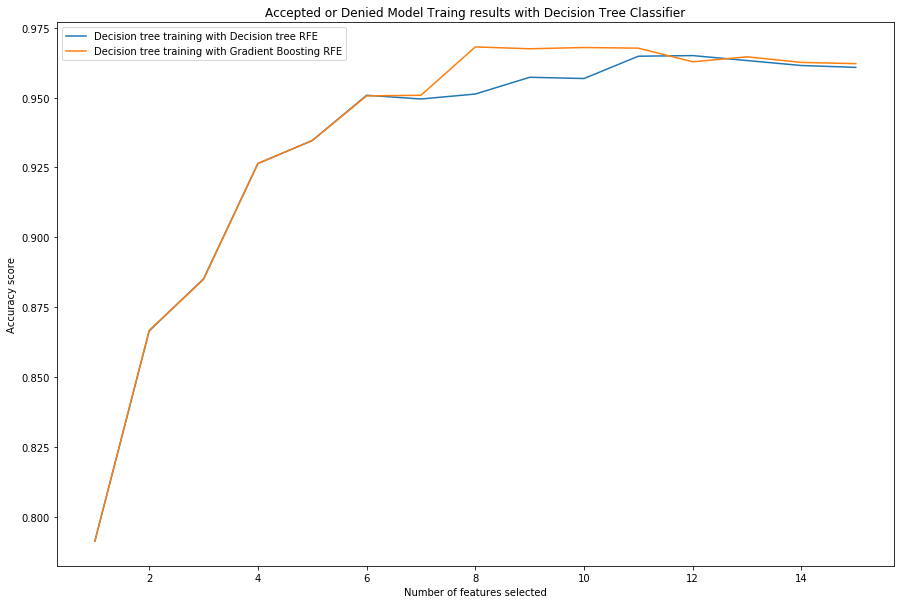

In [30]:
# line 1 points
# x1 = number_of_features
# y1 = accuracy_gradient_boost_gradient_boost_RFE
# # plotting the line 1 points 
# plt.plot(x1, y1, label = "Gradient boosting training with gradient boosting RFE")

# # line 2 points
# x2 = number_of_features
# y2 = accuracy_random_forest_gradient_boost_RFE
# # plotting the line 1 points 
# plt.plot(x2, y2, label = "Random forest training with gradient boosting RFE")


# # line 3 points
# x3 = number_of_features
# y3 = accuracy_random_forest_random_forest_RFE
# # plotting the line 2 points 
# plt.plot(x3, y3, label = "Random forest training with Random forest RFE")
fig = plt.figure(figsize=(15,10))
# line 4 points
x4 = number_of_features
y4 = accuracy_decision_tree_decision_tree_RFE
# plotting the line 2 points 
plt.plot(x4, y4, label = "Decision tree training with Decision tree RFE")

# line 5 points
x4 = number_of_features
y4 = accuracy_decision_tree_gradient_boosting_RFE
# plotting the line 2 points 
plt.plot(x4, y4, label = "Decision tree training with Gradient Boosting RFE")

plt.xlabel('Number of features selected')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy score')
# Set a title of the current axes.
plt.title('Accepted or Denied Model Traing results with Decision Tree Classifier')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()
fig.savefig("decisiontree-results.png")

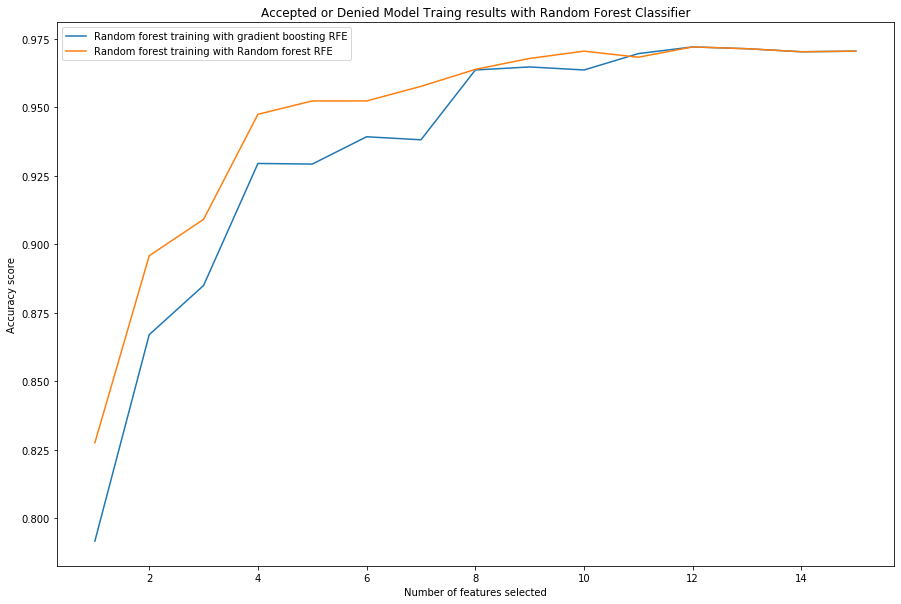

In [31]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))

# # line 1 points
# x1 = number_of_features
# y1 = accuracy_gradient_boost_gradient_boost_RFE
# # plotting the line 1 points 
# plt.plot(x1, y1, label = "Gradient boosting training with gradient boosting RFE")

# line 2 points
x2 = number_of_features
y2 = accuracy_random_forest_gradient_boost_RFE
# plotting the line 1 points 
plt.plot(x2, y2, label = "Random forest training with gradient boosting RFE")


# line 3 points
x3 = number_of_features
y3 = accuracy_random_forest_random_forest_RFE
# plotting the line 2 points 
plt.plot(x3, y3, label = "Random forest training with Random forest RFE")

# # line 4 points
# x4 = number_of_features
# y4 = accuracy_decision_tree_decision_tree_RFE
# # plotting the line 2 points 
# plt.plot(x4, y4, label = "Decision tree training with Decision tree RFE")

# # line 5 points
# x4 = number_of_features
# y4 = accuracy_decision_tree_gradient_boosting_RFE
# # plotting the line 2 points 
# plt.plot(x4, y4, label = "Decision tree training with Gradient Boosting RFE")

plt.xlabel('Number of features selected')
# Set the y axis label of the current axis.
plt.ylabel('Accuracy score')
# Set a title of the current axes.
plt.title('Accepted or Denied Model Traing results with Random Forest Classifier')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()
fig.savefig("random-forest-results.png")

In [32]:
for index in range(1, 16):
    decisionTreeRFELoop = RFE(tree.DecisionTreeClassifier(max_depth = 5),n_features_to_select = index)
    decisionTreeRFELoop.fit(X_train,y_train)
    X_train_dec_RFELoop = decisionTreeRFELoop.transform(X_train)
    X_test_dec_RFELoop = decisionTreeRFELoop.transform(X_test)
    print("number of selected features:", index)
    run_randomForest(X_train_dec_RFELoop, X_test_dec_RFELoop, y_train, y_test)
    print()

number of selected features: 1
Accuracy:  0.7917128296033681
Classification report:                precision    recall  f1-score   support

       False       0.74      1.00      0.85      2692
        True       0.99      0.49      0.65      1821

    accuracy                           0.79      4513
   macro avg       0.87      0.74      0.75      4513
weighted avg       0.84      0.79      0.77      4513


number of selected features: 2
Accuracy:  0.8670507423000221
Classification report:                precision    recall  f1-score   support

       False       0.86      0.94      0.89      2692
        True       0.89      0.77      0.82      1821

    accuracy                           0.87      4513
   macro avg       0.87      0.85      0.86      4513
weighted avg       0.87      0.87      0.87      4513


number of selected features: 3
Accuracy:  0.8849988920895192
Classification report:                precision    recall  f1-score   support

       False       0.86      0.96 

In [33]:
for index in range(1, 16):
    randomForestRFELoop = RFE(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1),n_features_to_select = index)
    randomForestRFELoop.fit(X_train,y_train)
    X_train_Rand_RFELoop = randomForestRFELoop.transform(X_train)
    X_test_Rand_RFELoop = randomForestRFELoop.transform(X_test)
    print("selected features:", index)
    run_decisionTree(X_train_Rand_RFELoop, X_test_Rand_RFELoop, y_train, y_test)
    print()

selected features: 1
Score:  0.8269443828938622
Classification report:                precision    recall  f1-score   support

       False       0.78      0.99      0.87      2692
        True       0.97      0.59      0.73      1821

    accuracy                           0.83      4513
   macro avg       0.87      0.79      0.80      4513
weighted avg       0.86      0.83      0.82      4513


selected features: 2
Score:  0.90006647462885
Classification report:                precision    recall  f1-score   support

       False       0.89      0.95      0.92      2692
        True       0.91      0.83      0.87      1821

    accuracy                           0.90      4513
   macro avg       0.90      0.89      0.89      4513
weighted avg       0.90      0.90      0.90      4513


selected features: 3
Score:  0.9080434300908486
Classification report:                precision    recall  f1-score   support

       False       0.90      0.95      0.92      2692
        True       0.